<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_07212021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)
  
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  ## set ground true expressions ##

  true_expression_means = torch.tensor([
      [3, 5],
      [6, 7],
      [9, 11]
  ])
  
  #true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]]
  ])

  true_size_means = torch.tensor([.4, .6, .8])
  #true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.01, .01, .01])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+4))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
  xxx = np.zeros((gs, n_features+4))
  for i in range(gs):

    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
  
    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]]), (true_expression_covs[idx[0]] + true_expression_covs[idx[1]]) ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
  xx = np.append(x, xxx).reshape(n_obs,6)

  ## check number of points in each cluster
  for i in range(9):
    print(sum(xx[:,5] == i)/n_obs)
  
  print(gs)

  return torch.tensor(xx[:,:2]), torch.tensor(xx[:,2])

## initialization
def initialization(n_clusters, X, S):

  n_obs, n_features = X.shape

  #torch.manual_seed(seed_num)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  #pi_d0 = torch.tensor(0.9)
  pi_d0 = torch.tensor(np.random.uniform(.9, 1))
  
  pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))
  
  pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
  pi_cc = pi_cc / torch.sum(pi_cc)
  pi_cc[pi_cc == 0] = float('NaN')

  emu_c = X[np.random.choice(n_obs, n_clusters, replace=False)].float()

  '''
  emu_c = torch.tensor([
    [2, 6], # 1 2
    [5, 8], # 4 3
    [9, 10] #7 9
  ], dtype=torch.float) #, requires_grad=True, , device=device)
  '''

  smu_c = S[np.random.choice(n_obs, n_clusters, replace=False)].float()
  #smu_c = torch.tensor([.3, .5, .7], dtype=torch.float) #, requires_grad=True,  device=device)

  eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
  sco_c = 0.01 * torch.ones(n_clusters, dtype=torch.float)

  smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
  sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

  emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
  eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if k >= j:
        smu_cc[j,k] = smu_c[j] + smu_c[k]
        sco_cc[j,k] = sco_c[j] + sco_c[k]

        emu_cc[j,k] = (emu_c[j] + emu_c[k])
        eco_cc[j,k] = (eco_c[j] + eco_c[k])

  params1 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
  sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
  emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
  eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
  smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
  sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
  emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
  eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

  hyperparams = [pi_d0, pi_c, pi_cc]
  params2 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  return hyperparams, params1, params2

In [2]:
n_clusters = 3
n_obs = 10000
n_features = 2

X, S = generateData(n_clusters, n_obs, n_features)

#X = torch.tensor(xx[:,:2])
#S = torch.tensor(xx[:,2])

0.0063
0.0078
0.0087
0.0101
0.005
0.0085
0.2135
0.6104
0.1297
464


In [3]:
def _estimate_mean_cov_t1v1(X, r_ij, reg=1e-6):

  n, p = X.shape
  n, c = r_ij.shape

  mut = torch.zeros(c, p)
  cot = torch.zeros(c, p, p)

  n_c = torch.sum(r_ij, dim=0) + reg # (c)

  for j in range(c):
    e_n = torch.round(n_c[j])
    idx = r_ij[:,j].argsort()[-e_n.int():]
    mut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      cot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(p)
    else:
      cot[j] = reg * torch.eye(p)
  return n_c, mut, cot

def _estimate_mean_cov_t2v1(X, r_ijk, reg=1e-6):

  n, p = X.shape
  n, c, c = r_ijk.shape

  mut = torch.zeros(c, c, p)
  cot = torch.zeros(c, c, p, p)

  n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

  for j in range(c):
    for k in range(c):
      if not torch.isnan(n_cc[j,k]):
        e_n = torch.round(n_cc[j,k])
        idx = r_ijk[:,j,k].argsort()[-e_n.int():]
        mut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          cot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(p)
        else:
          cot[j,k] = reg * torch.eye(p)
  return n_cc, mut, cot

## helper function
def _estimate_mean_cov_t1v2(X, S, r_ij, reg=1e-6):

  #n, p = X.shape
  #n, c = r_ij.shape

  smut = torch.zeros(n_clusters)
  scot = torch.zeros(n_clusters)

  emut = torch.zeros(n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_features, n_features)

  n_c = torch.sum(r_ij, dim=0) #+ reg # (c)

  for j in range(n_clusters):
    e_n = torch.round(n_c[j])
    idx = r_ij[:,j].argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(n_features)
      scot[j] = reg
  return n_c, smut, scot, emut, ecot

def _estimate_mean_cov_t2v2(X, S, log_rijk, reg=1e-6):

  n_obs, n_features = X.shape
  n_obs, n_clusters, n_clusters = log_rijk.shape

  smut = torch.zeros(n_clusters, n_clusters)
  scot = torch.zeros(n_clusters, n_clusters)

  emut = torch.zeros(n_clusters, n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_clusters, n_features, n_features)

  #n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)
  log_n_cc = torch.logsumexp(log_rijk, dim=0) # (cxc)
  #n_cc = torch.exp(log_n_cc) + reg

  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(torch.exp(log_n_cc[j,k])):
        e_n = torch.round(torch.exp(log_n_cc[j,k]))
        idx = torch.exp(log_rijk[:,j,k]).argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(n_features)
  return log_n_cc, smut, scot, emut, ecot

In [4]:
  n_epochs = 1000
  tot = 0.005

  import numpy as np
  from sklearn.mixture import GaussianMixture

In [ ]:
## GMM
torch.set_printoptions(precision=10)

for i in range(50):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]
  
  ## analytical version 1

  iter = 0
  qs = [0.0]
  ls = [0.0]

  while iter < n_epochs:

    log_pi = torch.log(pi_c)
    
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    
    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      #sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
      log_rd0z_top[j] = log_pi[j] + el0 #+ sl0
    
    log_rdzg_norm = log_rd0z_top.logsumexp(0) #shape: n
    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    
    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    Q = torch.logsumexp(q1, 1).mean()

    #l1 = log_rd0z_top.T + log_rdz
    #L1 = torch.logsumexp(l1,1).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, rdz)
    pi_c = n_c / n_obs

    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, pi_c)

    if abs(ls[-1] - L) < tot:
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break

    qs.append(Q)
    ls.append(L)
    iter += 1

In [19]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X)
gm.score(X)

-2.3407317163393464

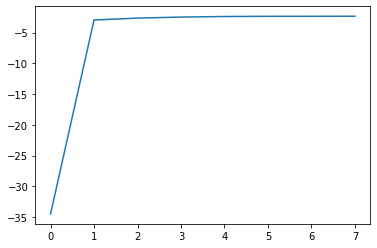

In [16]:
plt.plot(ls[1:])

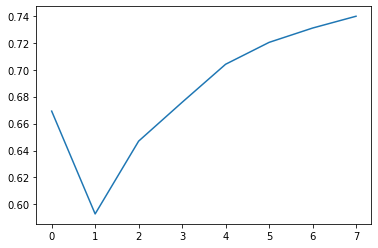

In [17]:
plt.plot(qs[1:])

In [5]:
## emu_c, eco_c updates
torch.set_printoptions(precision=5)

for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal((emu_c[j] + emu_c[k]), (eco_c[j] + eco_c[k])).log_prob(X.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

    assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
    Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

    l1 = log_rd0z_top.T + log_rdz
    l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, emu_c, eco_c = _estimate_mean_cov_t1v1(X, rdz)
    pi_c = n_c / n_obs
    pi_d0 = torch.sum(pi_c)

    rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
    n_cc = torch.sum(rdg, dim=0)
    pi_cc = n_cc / n_obs
    pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break
    
    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, L1, 'd0: ', pi_d0)

    qs.append(Q)
    ls.append(L)
    iter += 1

  aic, bic = _ics(-L, n_obs, n_features, n_clusters)
  print(aic)
  #return llv[1:], aic, bic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Iteration 1 Q:  tensor(2.09485) Likelihood:  tensor(-2.62570) tensor(-2.64206) d0:  tensor(0.93916)
Iteration 2 Q:  tensor(2.11450) Likelihood:  tensor(-1.90945) tensor(-1.91248) d0:  tensor(0.95226)
Iteration 3 Q:  tensor(2.11554) Likelihood:  tensor(-1.89287) tensor(-1.89402) d0:  tensor(0.95388)
tensor(138.21596)
Iteration 1 Q:  tensor(2.08234) Likelihood:  tensor(-2.55460) tensor(-2.63539) d0:  tensor(0.86378)
Iteration 2 Q:  tensor(2.10533) Likelihood:  tensor(-2.08476) tensor(-2.10718) d0:  tensor(0.93022)
Iteration 3 Q:  tensor(2.11356) Likelihood:  tensor(-1.92500) tensor(-1.93026) d0:  tensor(0.95053)
Iteration 4 Q:  tensor(2.11546) Likelihood:  tensor(-1.89434) tensor(-1.89558) d0:  tensor(0.95364)
tensor(138.21577)
Iteration 1 Q:  tensor(2.05660) Likelihood:  tensor(-19.03039) tensor(-19.44042) d0:  tensor(0.49282)
Iteration 2 Q:  tensor(2.02784) Likelihood:  tensor(-33.54848) tensor(-33.78198) d0:  tensor(0.49272)
something is wrong!
tensor(74.18137)
Iteration 1 Q:  tensor(

In [6]:
## emu_c, eco_c, smu_c, sco_c updates
for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]
  smu_c = ngps[2]
  sco_c = ngps[3]

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal((emu_c[j] + emu_c[k]), (eco_c[j] + eco_c[k])).log_prob(X.float())
          sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

    assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
    Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

    l1 = log_rd0z_top.T + log_rdz
    l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
    pi_c = n_c / n_obs
    pi_d0 = torch.sum(pi_c)

    rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
    #n_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, rdg)
    n_cc = torch.sum(rdg, dim=0)
    pi_cc = n_cc / n_obs
    pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break

    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, L1, 'd0: ', pi_d0)

    qs.append(Q)
    ls.append(L)
    iter += 1

  aic, bic = _ics(-L, n_obs, n_features, n_clusters)
  print(bic)
  #return llv[1:], aic, bic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Iteration 1 Q:  tensor(2.18476) Likelihood:  tensor(-426.26419) tensor(-426.27420) d0:  tensor(0.96630)
Iteration 2 Q:  tensor(2.16420) Likelihood:  tensor(-1.29059) tensor(-1.30396) d0:  tensor(0.96551)
Iteration 3 Q:  tensor(2.25265) Likelihood:  tensor(-0.58162) tensor(-0.58868) d0:  tensor(0.96199)
Iteration 4 Q:  tensor(2.40571) Likelihood:  tensor(0.26062) tensor(0.26062) d0:  tensor(0.96130)
Iteration 5 Q:  tensor(2.65259) Likelihood:  tensor(0.84429) tensor(0.84429) d0:  tensor(0.96130)
Iteration 6 Q:  tensor(2.65258) Likelihood:  tensor(0.98078) tensor(0.98078) d0:  tensor(0.96130)
Iteration 7 Q:  tensor(2.65183) Likelihood:  tensor(0.99163) tensor(0.98934) d0:  tensor(0.95797)
Iteration 8 Q:  tensor(2.66950) Likelihood:  tensor(1.13483) tensor(1.13310) d0:  tensor(0.95088)
Iteration 9 Q:  tensor(2.70625) Likelihood:  tensor(1.24186) tensor(1.24156) d0:  tensor(0.95050)
tensor(656.41888)
Iteration 1 Q:  tensor(2.29727) Likelihood:  tensor(-17.91623) tensor(-17.91641) d0:  tens

In [ ]:
## emu_c, eco_c, smu_c, sco_c updates and divide by 2 (no good)
for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]
  smu_c = ngps[2]
  sco_c = ngps[3]

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal((emu_c[j] + emu_c[k]), (eco_c[j] + eco_c[k])).log_prob(X.float())
          sl1 = D.Normal((smu_c[j] + smu_c[k])/2, (sco_c[j] + sco_c[k])/2).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

    assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
    Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

    l1 = log_rd0z_top.T + log_rdz
    l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
    pi_c = n_c / n_obs
    pi_d0 = torch.sum(pi_c)

    rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
    #n_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, rdg)
    n_cc = torch.sum(rdg, dim=0)
    pi_cc = n_cc / n_obs
    pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break

    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, L1, 'd0: ', pi_d0)

    qs.append(Q)
    ls.append(L)
    iter += 1

  aic, bic = _ics(-L, n_obs, n_features, n_clusters)
  print(bic)
  #return llv[1:], aic, bic

In [8]:
## emu_c, eco_c, smu_c, sco_c and
## emu_cc, eco_cc, smu_cc, sco_cc updates 

for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]
  smu_c = ngps[2]
  sco_c = ngps[3]

  emu_cc = ngps[4]
  eco_cc = ngps[5]
  smu_cc = ngps[6]
  sco_cc = ngps[7]

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal(emu_cc[j,k], eco_cc[j,k]).log_prob(X.float())
          sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

    assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
    Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

    l1 = log_rd0z_top.T + log_rdz
    l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
    pi_c = n_c / n_obs
    pi_d0 = torch.sum(pi_c)

    rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
    n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, rdg)
    #n_cc = torch.sum(rdg, dim=0)
    pi_cc = n_cc / n_obs
    pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break

    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, L1, 'd0: ', pi_d0)

    qs.append(Q)
    ls.append(L)
    iter += 1

  aic, bic = _ics(-L, n_obs, n_features, n_clusters)
  print(aic)
  #return llv[1:], aic, bic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Iteration 1 Q:  tensor(2.32263) Likelihood:  tensor(-23.73178) tensor(-23.73534) d0:  tensor(0.55624)
Iteration 2 Q:  tensor(2.04002) Likelihood:  tensor(-3.65930) tensor(-4.42582) d0:  tensor(0.57221)
Iteration 3 Q:  tensor(2.04654) Likelihood:  tensor(-3.62787) tensor(-4.39383) d0:  tensor(0.57254)
tensor(134.74498)
Iteration 1 Q:  tensor(2.07375) Likelihood:  tensor(-381.22543) tensor(-381.22931) d0:  tensor(0.57271)
Iteration 2 Q:  tensor(1.97723) Likelihood:  tensor(-3.75020) tensor(-4.51585) d0:  tensor(0.57259)
Iteration 3 Q:  tensor(2.04649) Likelihood:  tensor(-3.62746) tensor(-4.39341) d0:  tensor(0.57254)
tensor(134.74500)
Iteration 1 Q:  tensor(2.31144) Likelihood:  tensor(-30.87618) tensor(-30.87679) d0:  tensor(0.49210)
Iteration 2 Q:  tensor(1.95540) Likelihood:  tensor(-4.34535) tensor(-5.25536) d0:  tensor(0.49199)
tensor(133.30678)
Iteration 1 Q:  tensor(1.96386) Likelihood:  tensor(-540.96759) tensor(-541.25555) d0:  tensor(0.96140)
Iteration 2 Q:  tensor(2.17482) Li

In [13]:
## emu_c, eco_c, smu_c, sco_c and
## emu_cc, eco_cc, smu_cc, sco_cc updates 
## divide by 2

for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  emu_c = ngps[0]
  eco_c = ngps[1]
  smu_c = ngps[2]
  sco_c = ngps[3]

  emu_cc = ngps[4]
  eco_cc = ngps[5]
  smu_cc = ngps[6]
  sco_cc = ngps[7]

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
      sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
          sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
    log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

    assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

    q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
    q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
    Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

    l1 = log_rd0z_top.T + log_rdz
    l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
    L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()
    L = log_rdzg_norm.mean()

    ## M-step:
    rdz = torch.exp(log_rdz)
    n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
    pi_c = n_c / n_obs
    pi_d0 = torch.sum(pi_c)

    rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
    n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, rdg)
    #n_cc = torch.sum(rdg, dim=0)
    pi_cc = n_cc / n_obs
    pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > L:
      print("something is wrong!")
      break

    print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', L, L1, 'd0: ', pi_d0)

    qs.append(Q)
    ls.append(L)
    iter += 1

  aic, bic = _ics(-L, n_obs, n_features, n_clusters)
  print(aic)
  #return llv[1:], aic, bic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Iteration 1 Q:  tensor(2.09831) Likelihood:  tensor(-30.75802) tensor(-30.76001) d0:  tensor(0.49210)
Iteration 2 Q:  tensor(1.90042) Likelihood:  tensor(-6.85950) tensor(-7.76970) d0:  tensor(0.49193)
tensor(128.27779)
Iteration 1 Q:  tensor(2.07925) Likelihood:  tensor(-103.69984) tensor(-103.70016) d0:  tensor(0.88055)
Iteration 2 Q:  tensor(2.50820) Likelihood:  tensor(-0.94709) tensor(-1.16144) d0:  tensor(0.88044)
tensor(140.10538)
Iteration 1 Q:  tensor(2.18318) Likelihood:  tensor(-55.65486) tensor(-55.89309) d0:  tensor(0.87206)
Iteration 2 Q:  tensor(2.47057) Likelihood:  tensor(-1.04297) tensor(-1.36639) d0:  tensor(0.87374)
Iteration 3 Q:  tensor(2.46491) Likelihood:  tensor(-1.01748) tensor(-1.33276) d0:  tensor(0.87702)
Iteration 4 Q:  tensor(2.45194) Likelihood:  tensor(-0.97931) tensor(-1.28871) d0:  tensor(0.87964)
Iteration 5 Q:  tensor(2.44162) Likelihood:  tensor(-0.96790) tensor(-1.27530) d0:  tensor(0.88023)
tensor(140.06624)
Iteration 1 Q:  tensor(2.24045) Likeli

In [ ]:
## choose between (emu_c/eco_c, smu_c, sco_c) and (emu_c/eco_c, smu_c/sco_c, emu_cc/eco_cc, smu_cc/sco_cc) models (no divide by 2)

In [ ]:
## (emu_c/eco_c, smu_c/sco_c, emu_cc/eco_cc, smu_cc/sco_cc) updates (no good)
for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  opt = optim.Adam(gps)

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(gps[0][j], gps[1][j]).log_prob(X.float())
      sl0 = D.Normal(gps[2][j], gps[3][j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal(gps[4][j,k], gps[5][j,k]).log_prob(X.float())
          sl1 = D.Normal(gps[6][j,k], gps[7][j,k]).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    loss = -log_rdzg_norm.mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    with torch.no_grad():

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      ## M-step:
      rdz = torch.exp(log_rdz)
      #n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
      n_c = torch.sum(rdz, dim=0)
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      #n_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, rdg)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] + loss) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > -loss:
      print("something is wrong!")
      break

    qs.append(Q)
    ls.append(-loss)
    iter += 1
  
  print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', -loss, L1, 'd0: ', pi_d0)
  aic, bic = _ics(loss, n_obs, n_features, n_clusters)
  print(bic)
  #return llv[1:], aic, bic

In [5]:
## emu_c, eco_c, smu_c, sco_c updates
for i in range(10):
  
  hps, ngps, gps = initialization(n_clusters, X, S)
  pi_d0 = hps[0]
  pi_d1 = 1-hps[0]
  pi_c = hps[1]
  pi_cc = hps[2]

  opt = optim.Adam(gps[:4])

  iter = 0
  qs = [0.0]
  ls = [0.0]

  #print(emu_c)
  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)

    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)

    for j in range(n_clusters):
  
      el0 = D.MultivariateNormal(gps[0][j], gps[1][j]).log_prob(X.float())
      sl0 = D.Normal(gps[2][j], gps[3][j]).log_prob(S.float())
      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          el1 = D.MultivariateNormal((gps[0][j] + gps[0][k]), (gps[1][j] + gps[1][k])).log_prob(X.float())
          sl1 = D.Normal(gps[2][j] + gps[2][k], gps[3][j] + gps[3][k]).log_prob(S.float())
          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    loss = -log_rdzg_norm.mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    with torch.no_grad():

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0 #p(x,theta'|z=c,d=0)p(z=c,d=0|x,theta')
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0 #p(x,theta'|g=[c,c'],d=1)p(g=[c,c'],d=1|x,theta')
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean() # mean(sum_d sum_z(q1) + sum_g(q2))

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      ## M-step:
      rdz = torch.exp(log_rdz)
      #n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, rdz)
      n_c = torch.sum(rdz, dim=0)
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      #n_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, rdg)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

    if abs(ls[-1] + loss) < tot:
      break

    if pi_d1 < tot:
      print("d1 is approaching 0! -> change a different initalization values")
      break

    if iter > 1 and ls[-1] > -loss:
      print("something is wrong!")
      break

    qs.append(Q)
    ls.append(-loss)
    iter += 1
  
  print('Iteration', iter + 1, 'Q: ', Q, 'Likelihood: ', -loss, L1, 'd0: ', pi_d0)
  aic, bic = _ics(loss, n_obs, n_features, n_clusters)
  print(bic)
  #return llv[1:], aic, bic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Iteration 295 Q:  tensor(2.1940) Likelihood:  tensor(-2.4868, grad_fn=<NegBackward>) tensor(-2.4869) d0:  tensor(0.8239)
tensor(648.9605, grad_fn=<AddBackward0>)
Iteration 307 Q:  tensor(2.2197) Likelihood:  tensor(-2.4646, grad_fn=<NegBackward>) tensor(-2.4646) d0:  tensor(0.8239)
tensor(649.0049, grad_fn=<AddBackward0>)
Iteration 572 Q:  tensor(2.4264) Likelihood:  tensor(-3.7113, grad_fn=<NegBackward>) tensor(-3.7113) d0:  tensor(0.8239)
tensor(646.5116, grad_fn=<AddBackward0>)
Iteration 370 Q:  tensor(2.2932) Likelihood:  tensor(-3.4288, grad_fn=<NegBackward>) tensor(-3.4355) d0:  tensor(0.8239)
tensor(647.0765, grad_fn=<AddBackward0>)
Iteration 344 Q:  tensor(2.2814) Likelihood:  tensor(-2.0582, grad_fn=<NegBackward>) tensor(-2.0591) d0:  tensor(0.8239)
tensor(649.8177, grad_fn=<AddBackward0>)
Iteration 329 Q:  tensor(2.1498) Likelihood:  tensor(-1.9770, grad_fn=<NegBackward>) tensor(-1.9778) d0:  tensor(0.8243)
tensor(649.9802, grad_fn=<AddBackward0>)
Iteration 302 Q:  tensor(2.2

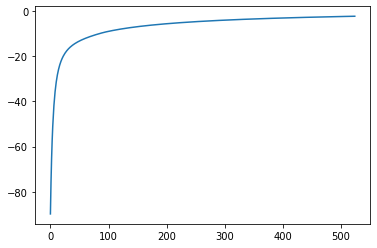

In [6]:
plt.plot(ls[1:])

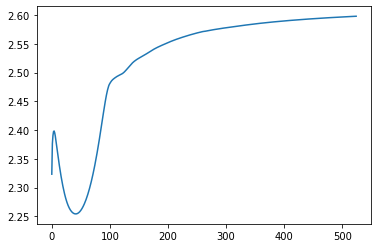

In [7]:
plt.plot(qs[1:])

In [8]:
pi_d0

tensor(0.9609)

In [9]:
pi_c

tensor([0.2178, 0.1370, 0.6061])

In [10]:
pi_cc

tensor([[0.0068, 0.0058, 0.0000],
        [   nan, 0.0085, 0.0042],
        [   nan,    nan, 0.0138]])

In [ ]:
0.0063
0.0078
0.0087
0.0101
0.005
0.0085
0.2135
0.6104
0.1297
464

In [12]:
gps[0]

tensor([[ 5.8606,  6.5523],
        [ 8.8333, 10.9417],
        [ 6.0039,  7.0137]], requires_grad=True)

In [13]:
gps[2]

tensor([0.4717, 0.7301, 0.6000], requires_grad=True)